# Learning objective

This notebook demonstrates how to solve the Fermi&ndash;Pasta&ndash;Ulam&ndash;Tsingou problem and how to interpret the nonlinear dynamics. Example and discussion of "recurrence" is given. Some key corrections to the codes in papers/books are noted.

# Preliminaries

In [ ]:
# interactive plots setup
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# sympy setup
import sympy as sp
sp.init_printing()
from sympy.vector import *

# ploting customizations
from matplotlib import pyplot as plt
size=16
params = {'legend.fontsize': 'large',
#          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.875,
          'ytick.labelsize': size*0.875,
          'axes.titlepad': 25,
          'animation.embed_limit': 2**128}
plt.rcParams.update(params)
%matplotlib inline
from matplotlib import colormaps
from mpl_toolkits.mplot3d import axes3d

# for animations
from matplotlib import animation, rc
from IPython.display import HTML

# numerics
import numpy as np
from scipy.integrate import solve_ivp
from scipy import fft
from scipy.interpolate import griddata

# to save plots as files and download them
#from google.colab import files

## Credit

Initial version written by [Ivan C. Christov](http://christov.tmnt-lab.org), Purdue University.

Code adapted from MATLAB version by T. Dauxois, M. Peyrard M. and S. Ruffo, [The Fermi-Pasta-Ulam numerical experiment: history and pedagogical perspectives](https://iopscience.iop.org/article/10.1088/0143-0807/26/5/S01), _European Journal of Physics_ *26* (2005) S3-S11. (Some typos in their code and discussion had to be corrected, but I don't go into the details ...)

See also
*   https://en.wikipedia.org/wiki/Fermi-Pasta-Ulam-Tsingou_problem
*   The original FPUT Los Alamos report https://www.osti.gov/servlets/purl/4376203

# Setting up the system of ODEs for the chain

The FPUT model is a series of point masses (mass $m$) and springs (stiffness $\kappa$) with a _nonlinear_ restoring force (quantified by the coupling constant $\alpha$). The displacement $u$ of the $j$th mass obeys Newton's 2nd law:
$$ m\ddot{u}_j(t) = \kappa[(u_{j+1} - u_j) + \alpha (u_{j+1} - u_j)^2] - \kappa[(u_j - u_{j-1}) + \alpha(u_j - u_{j-1})^2],\quad j=0,\dots,N-1.$$

As $\alpha\to0$, we recover the linear spring-mass chain; so, $\alpha$ might be expected to be "small'' (with respect to some suitable scale).

In [ ]:
# parameters
# Nm = number of masses in chain
Nm = 32
# alpha = nonlinear coupling constant
alpha = 0.25

It is customary to rescale time as $t\mapsto t/(h/c)$ and so that $k$ and $m$ are removed from the equation. (Recall that $c^2 = KL^2/M$ and $K = \kappa/N$, $M=mN$, and $h$ is the mass spacing/spring length for the spring-mass chain/lattice.)

There are $N$ of these _second-order_ ordinary differential equations (ODEs) coupled together.

But, the black-box ODE solver will only take a system of _first-order_ ODEs, so we make the following trivial change (introducing the _velocity_ $v_j$ and rescaling $t$):
$$ \begin{cases} \dot{u}_j &= v_j,\\ \dot{v}_j &= (u_{j+1} - 2u_j + u_{j-1}) + \alpha[(u_{j+1} - u_i)^2 - (u_j - u_{j-1})^2].\end{cases}$$

Now, there are $2N$ of these equations coupled together. Denote the left-hand side as $d\vec{y}/dt$ where $\vec{y} = ({u}_0, \dots, {u}_{N-1}, {v}_0, \dots, {v}_{N-1})$, and the right-hand side by $\vec{F}$.  

Define a python function to construct $\vec{F}$ given $t$, $\vec{y}$, $N$, and $\alpha$:

In [ ]:
# ODE system right-hand side
#   allow the function to take local values of N and alpha
#   so we can run it multiple times in the notebook
#
#   note that python uses 0-indexed arrays (-1 all MATLAB indeces)
#   ... also be careful with 'range' and the interval endpoint

def fput(t,y,N,alph):
  F = np.empty(2*N)

  # interior nodes, j=0 and j=N-1, require special care (BCs for j=-1 and j=N)
  # set \dot{u}_{0}, \dot{u}_{N-1} from v values from y vector (by defn., no BC needed)
  F[0] = y[N]
  F[N-1] = y[2*N-1]
  # fixed BCs: u_{-1} = 0, u_{N} = 0 to determine F for boundary masses
  F[N] = y[1] - 2*y[0] + 0 + alph*((y[1]-y[0])**2 - (y[0]-0)**2)
  F[2*N-1] = 0 - 2*y[N-1] + y[N-2] + alph*((0 - y[N-1])**2 - (y[N-1]-y[N-2])**2)

  # remaining nodes, j = 1 to N-2, per the ODE formula
  for j in range(1,N-1):
    F[j]   = y[j+N]
    F[j+N] = y[j+1] - 2*y[j] + y[j-1] \
             + alph*((y[j+1]-y[j])**2 - (y[j]-y[j-1])**2)

  return F

**Note:** At the end points, $j=0$ and $j=N-1$, we have to apply _boundary conditions_ (BCs) because there the displacements $u_{j-1=-1}$ and $u_{j+1=N}$, respectively, are undefined. Some possibilities are:

1.   Periodic BCs: $u_{-1} = u_{N}$ and $u_{N} = u_0$.
2.   Fixed BCs: $u_{-1}=u_{N}=0$.
3.   A combination of BCs: say, drive the left end at a given displacement $u_0=f(t)$ and fix the right end $u_{N}=0$.

The second case is implemented above. Try some of the others on your own!

In all three cases  $v_0=\dot{u}_0$ and $v_{N-1} = \dot{u}_{N-1}$ (for consistency with definition of $v$), so no BCs are needed for the $v_j$ in $\vec{F}$.

# Solving the system of ODEs

Now, we wish to solve the ODE intial-value problem (IVP), given the displacements $u_j$ and velocities $v_j$ at all the nodes at $t=0$.

In [ ]:
# simulation parameters
# maximum integration time
tmax = 10000.
# output time step
dt = 20.
tnum = int(np.floor(tmax/dt))
tspan = np.linspace(0.,tmax,num=tnum)

# try: test different tolerances for the integrator, changing reltol
reltol = 1e-4

Traditionally, the initial conditions are chosen as some combination of the natural vibration modes of the lattice. For a lattices with two fixed ends, these modes take the form
$$
  u_j(t=0) = \mathrm{Im}\left\{ \mathrm{e}^{\mathrm{i}k_n j} \right\} = \sin(k_n j).
$$
[**Note:** it's only "$j$" and not "$jh$" after $k_n$ because we rescaled time as $t\mapsto t/(h/c)$. Effectively, the time to traverse one lattice site is now $1$, the speed is $1$ and the spacing is $1$.]
The subscript $n$ on $k$ anticipates that only a finite, enumerable set of $k$ values will be allowed.

The presence of the "ghost" masses/nodes at $j=-1$ and $N$ effectively make the chain of length $N+2$. To get the math straight, we should imagine indices are shifted from $j=-1,...,N$ to $j=0,...,N+1$ (so in the code below you might see $j+1$ in some places to ensure this shift).

Then, the BCs $u_{-1+1=0}=0$ and $u_{N+1}=0$ determine the allowable wavenumbers:
$$
  \sin(0) = \sin(k_n(N+1)) =0 \qquad\Leftrightarrow\qquad k_n = \frac{n \pi}{N+1},\qquad n=0,1,....
$$

In [ ]:
# choose an initial condition
yic = np.empty(2*Nm)
for j in range(0,Nm):
  # orignal FPUT, displacement but no velocity
  a = 1.
  yic[j] = a*np.sin(np.pi*(j+1)/(Nm+1))
  yic[j+Nm] = 0

  # Zabusky--Deem : careful with the amplitude
  # a = 0.2
  # yic[j] = a*np.sin(np.pi*Nm*(j+1)/(Nm+1))
  # yic[j+Nm] = 0

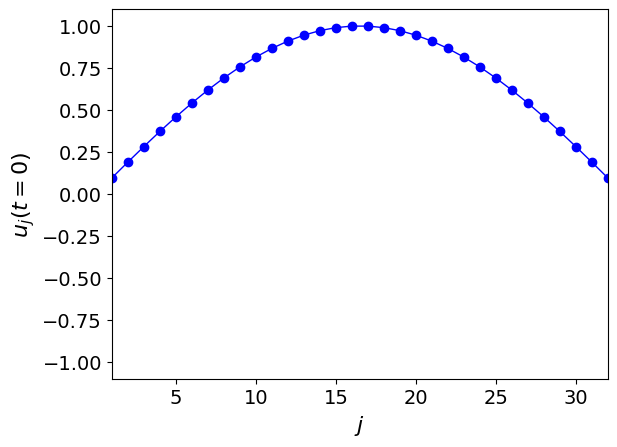

In [ ]:
# plot the initial displacements
x = np.linspace(1,Nm+1,num=Nm,endpoint=False)
fig, ax = plt.subplots()
ax.plot(x, yic[0:Nm], color='blue', linewidth=1, marker='o')
#ax.plot(x, yic[Nm:2*Nm], color='red', linewidth=1, marker='x')
ax.set_ylim(-1.1,1.1)
ax.set_ylabel('$u_j(t=0)$')
ax.set_xlim(1,Nm)
ax.set_xlabel('$j$');

We use SciPy's [`solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) to numerically integrate the system of $2N$ ODEs forward in time using the classical [RK45](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta%E2%80%93Fehlberg_method) method with time-step adaptation and error control.

In [ ]:
# simulate the nonlinear chain
sol = solve_ivp(fun=fput, args=(Nm, alpha, ),
                t_span=[0,tmax], y0=yic, t_eval=tspan,
                method='RK45', rtol=reltol, dense_output=True)

# also simulate a _linear_ chain (alpha=0), for comparison
sol_lin = solve_ivp(fun=fput, args=(Nm, 0., ),
                    t_span=[0,tmax], y0=yic, t_eval=tspan,
                    method='RK45', rtol=reltol, dense_output=True)

# Plotting the solution

## Static plot

First, just quick static plot of the final shapes. Lighter colors are the solution to the linear chain.

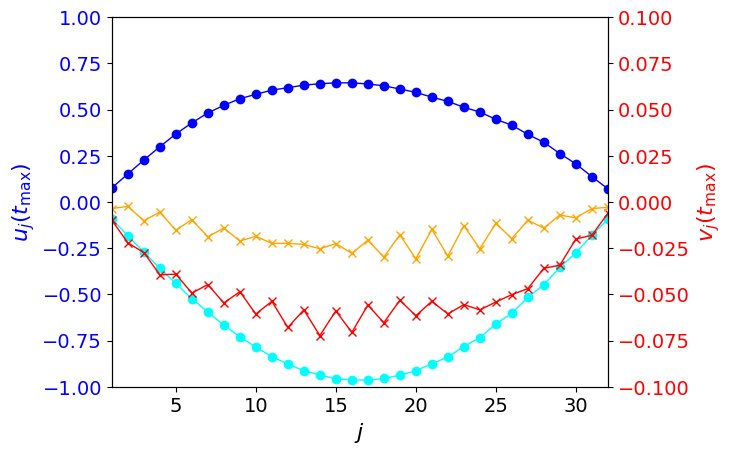

In [ ]:
x = np.linspace(1,Nm+1,num=Nm,endpoint=False)
solt = sol.sol(tmax)
uj = solt[0:Nm]
vj = solt[Nm:2*Nm]
solt_lin = sol_lin.sol(tmax)
uj_lin = solt_lin[0:Nm]
vj_lin = solt_lin[Nm:2*Nm]

fig, ax1 = plt.subplots()

# displacements on the left axis
ax1.plot(x, uj, linewidth=1, marker='o', color='blue')
ax1.plot(x, uj_lin, linewidth=1, marker='o', color='cyan')
ax1.set_ylabel('$u_j(t_\mathrm{max})$', color='blue')
ax1.set_ylim(-1,1)
ax1.set_xlabel('$j$')
ax1.set_xlim(1,Nm)
ax1.tick_params(axis='y', labelcolor='blue')

# velocities on the right axis
ax2 = ax1.twinx()
ax2.plot(x, vj, linewidth=1, marker='x', color='red')
ax2.plot(x, vj_lin, linewidth=1, marker='x', color='orange')
ax2.set_ylim(-0.1,0.1)
ax2.set_ylabel('$v_j(t_\mathrm{max})$', color='red')
ax2.tick_params(axis='y', labelcolor='red')

## Animation

Next, we visualize our results using our snazzy animation tools.

In [ ]:
# set up the figure and axes
fig, ax = plt.subplots()
ax.set_ylabel('displacement $u_j(t)$')
ax.set_xlabel('mass position $j$')
ax.set_xlim(1,Nm)
ax.set_ylim(-1,1)
# nice dynamic label to show time
ttl = ax.text(0.825, 0.925, '', size='large',
              #bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),
              transform=ax.transAxes, animated=True)
# so axes labels aren't cut off
plt.tight_layout()
plt.close()

# initialize plot objects with some dummy data (replaced in animation)
line1, = ax.plot(x, 0*x, color='blue', linewidth=1, marker='o')
line2, = ax.plot(x, 0*x, color='cyan', linewidth=1, marker='o')

#ax.plot(x, vj, color='red', linewidth=1,
#        marker='x', markerfacecolor='red')

# animation function called sequentially by `FuncAnimation' below
def animate(t):
  # grab solution at this t value from the output of solve_ivp
  solt = sol.sol(t)
  uj = solt[0:Nm]
  #vj = solt[Nm:2*Nm]
  line1.set_data(x, uj)
  solt_lin = sol_lin.sol(t)
  uj_lin = solt_lin[0:Nm]
  #vj_lin = solt[Nm:2*Nm]
  line2.set_data(x, uj_lin)

  ttl.set_text(f'$t=${t:.0f}')

  return (line1, line2, ttl, )

framran = range(0,int(tmax)+1,50)

anim = animation.FuncAnimation(fig, animate, frames=framran, interval=100, blit=True)

# this is necessary to get the animation to work on Google's Colab
rc('animation', html='jshtml')
anim

# Further explorations

## Energetics

It is useful to consider the evolution of the normal modes (harmonics). For a linear problem, we could represent the _exact_ solution this way.

Using the same re-scaling for frequency as for time (to get rid of the spring constant $\kappa$ and mass $m$), consider **global** modes defined on the whole chain by summing up all the contributions $\sin(k_n j)$ at each lattice site $j$, as:
$$
  \left. \begin{align}
  A_n &= \sqrt{\frac{2}{N+1}} \sum_{j=1}^{N} u_j \sin\left(\frac{n \pi j}{N+1}\right),\\
  \omega(k_n) = \omega_n &= 2 \sin\left(\frac{n \pi}{2(N+1)}\right)
  \end{align}\right\} \quad n=1,\dots,N.
$$

As mentioned above, owing to the two fixed masses (boundary conditions $u_{0}=u_{N+1}=0$), the lattice is effectively of length $N+2$ and indeces are shifted from $j=-1,...,N$ to $j=0,...,N+1$ in the equations for clarity. Mode $n=0$ and its "alias" $n=N+1$, obviously, have no energy content, so they do not need to be included in the sum.

Here, $\omega_n$ is the $n$th "global" mode frequency, and $A_n$ is its amplitude, composed of sinusoidal oscillations with magnitude $u_j$ at chain site $j$. As we discussed, a chain with fixed end $u_{N+1}=0$ only admit sinusoidal modes at the discrete frequencies $\omega_n$.


In [ ]:
# (square of) normal mode frequencies
omegak2 = np.empty(Nm+2)
for n in range(0,Nm+2):
  omegak2[n] = 4.*np.sin(np.pi*n/(2*(Nm+1)))**2

We compute the evolution of normal modes (and their energy) in time from the numerical solution of the chain dynamics. In this way, we can understand the effect of nonlinearity introduced by $\alpha$.

The total (kinetic+potential) energy in the chain is then defined as (see FPUT report):
$$
  E = \frac{1}{2}\sum_{n=1}^N \dot{A}_n^2 + \omega_n^2 A_n^2.
$$
Note that
$$
  \dot{A}_n = \sqrt{\frac{2}{N+1}} \sum_{j=1}^{N} \underbrace{v_j}_{=\dot{u}_j} \sin\left(\frac{n \pi j}{N+1}\right).
$$

Because we are looking for a decomposition into sine modes only (the $\dot{A}_n$ are the Fourier transform of the $v_j$ and the $A_n$ of the $u_j$), we perform a type-I _discrete sine transform_ (DST), which is easily done using [SciPy's FFT routines](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.dst.html).

In [ ]:
# normal mode amplitudes extracted from solution via FFT
energk = np.empty((tnum,Nm))
energk_lin = np.empty((tnum,Nm))
time = np.empty(tnum)
for it in range(0,tnum):
  # normalized time to compare to orginal FPUT plot
  time[it] = it*dt*np.sqrt(omegak2[1])/(2*np.pi)

  # grab mass displacements solution (nonlinear chain)
  solt = sol.sol(it*dt)
  uj = solt[0:Nm]
  vj = solt[Nm:2*Nm]
  fftu = fft.dst(uj,type=1)/np.sqrt(2*(Nm+1))
  fftv = fft.dst(vj,type=1)/np.sqrt(2*(Nm+1))
  energk[it,:] = (omegak2[1:Nm+1]*fftu**2+fftv**2)/2

  # grab mass displacements solution (linear chain)
  solt_lin = sol_lin.sol(it*dt)
  uj_lin = solt_lin[0:Nm]
  vj_lin = solt_lin[Nm:2*Nm]
  fftu_lin = fft.dst(uj_lin,type=1)/np.sqrt(2*(Nm+1))
  fftv_lin = fft.dst(vj_lin,type=1)/np.sqrt(2*(Nm+1))
  energk_lin[it,:] = (omegak2[1:Nm+1]*fftu_lin**2+fftv_lin**2)/2

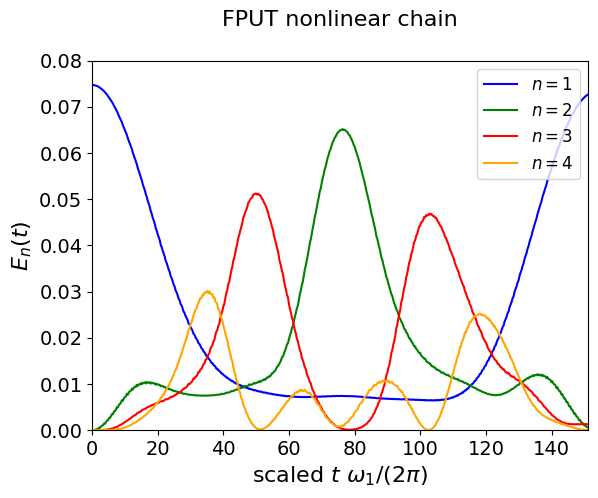

In [ ]:
# set up the figure and axes
fig, ax = plt.subplots()
ax.set_ylabel('$E_n(t)$')
ax.set_ylim(0,0.08)
ax.set_xlabel('scaled $t$ $\omega_1/(2\pi)$')
ax.set_xlim(time.min(),time.max())
ax.plot(time, energk[:,0], color='blue', label='$n=1$')
ax.plot(time, energk[:,1], color='green', label='$n=2$')
ax.plot(time, energk[:,2], color='red', label='$n=3$')
ax.plot(time, energk[:,3], color='orange', label='$n=4$')
ax.set_title('FPUT nonlinear chain')
ax.legend(loc='best');

In the nonlinear chain, energy is exchanged between modes. Nevertheless, it appears that, by the end of the simulation time, all the energy has returned to mode $n=1$. This surprinsing phenomenon is known as a _recurrence_.

Dauxois _et al._ report that $t_\mathrm{recur} \omega_1/(2\pi)\approx 157 $ (i.e., $t_\mathrm{recur} \approx 157$ times the period, $2\pi/\omega_1$, of the $n=1$ mode) for the FPUT initial condition. Let's check.

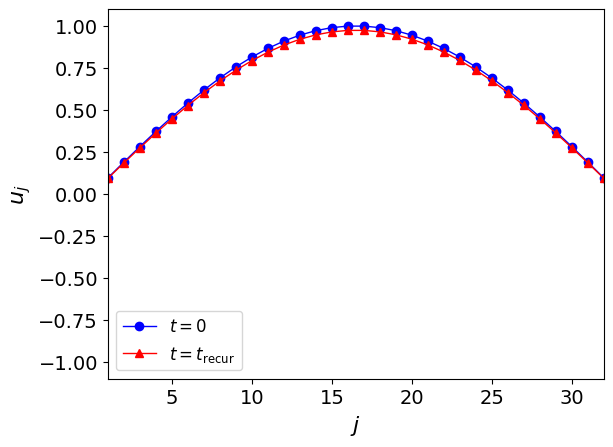

In [ ]:
fig, ax = plt.subplots()
# plot IC (t=0)
ax.plot(x, yic[0:Nm], color='blue', lw=1, marker='o', label='$t=0$')
# plot solution at t=t_recur to check recurrrence
trecur = 157*np.sqrt(omegak2[1])/(2*np.pi)
solt = sol.sol(trecur)
uj = solt[0:Nm]
ax.plot(x, uj, color='red', lw=1, marker='^', label='$t=t_\mathrm{recur}$')

ax.set_ylim(-1.1,1.1)
ax.set_ylabel('$u_j$')
ax.set_xlim(1,Nm)
ax.set_xlabel('$j$')
ax.legend(loc='best');

Now, we can also plot the linear chain's energetics.

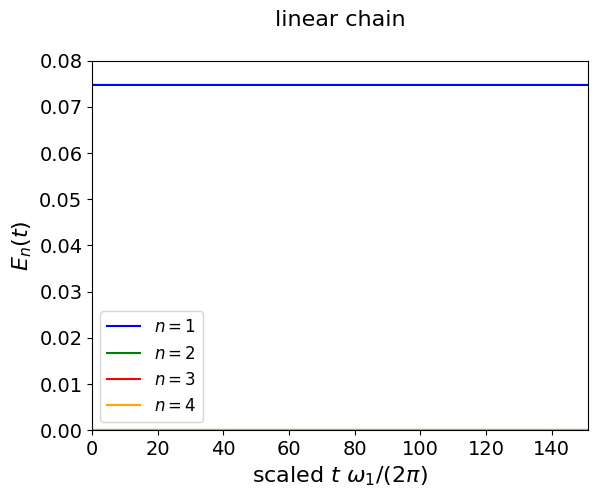

In [ ]:
# set up the figure and axis
fig, ax = plt.subplots()
ax.set_ylabel('$E_n(t)$')
ax.set_ylim(0,0.08)
ax.set_xlabel('scaled $t$ $\omega_1/(2\pi)$')
ax.set_xlim(time.min(),time.max())
ax.plot(time, energk_lin[:,0], color='blue', label='$n=1$')
ax.plot(time, energk_lin[:,1], color='green', label='$n=2$')
ax.plot(time, energk_lin[:,2], color='red', label='$n=3$')
ax.plot(time, energk_lin[:,3], color='orange', label='$n=4$')
ax.set_title('linear chain')
ax.legend(loc='best');

In a linear chain in which we've only excited the $n=1$ global mode, no other modes can be generated. The energy content remains in mode $n=1$ for all $t$.

## Space-time view of the dynamics

A cool way to visualize the dynamics in space at discrete times is a [waterfall plot](https://www.mathworks.com/help/matlab/ref/waterfall.html). I tried to do something similar using [Matplotlib](https://matplotlib.org/stable/gallery/mplot3d/wire3d_zero_stride.html#sphx-glr-gallery-mplot3d-wire3d-zero-stride-py) and some hacks.

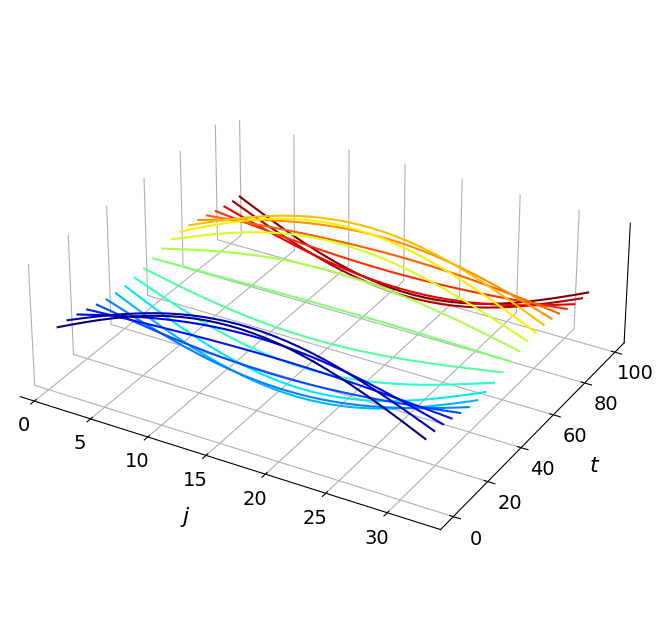

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8),
                       subplot_kw={'projection': '3d'})

ax.set_box_aspect(aspect=None, zoom=0.85) # so axis labels don't get cutoff

plot_ts = range(0,100)

X3D, Y3D = np.meshgrid(x, plot_ts) # Y is time here
Z3D = np.zeros_like(X3D)

for it in plot_ts:
  solt = sol.sol(it)
  uj = solt[0:Nm]

  # hack to plot only line wire at a time, with appropriate color each time
  Z3D[:,:] = np.nan
  Z3D[it,:] = 5*uj

  ax.plot_wireframe(X3D, Y3D, Z3D,
                    rstride=5, cstride=0,
                    color=colormaps['jet'](it/max(plot_ts)))

ax.set_xlabel('$j$')
ax.xaxis.labelpad=20
ax.set_ylabel('$t$')
ax.yaxis.labelpad=10
#ax.set_zlabel('$u_j$')
ax.set_zticks([])

#ax.axis('off')

ax.set_aspect('equalxz')
ax.grid(axis='z',visible=False)

# Get rid of colored axes planes
# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

## Solitons in the strain field

The long-wave limit PDE of the FPUT nonlinear chain is a KdV equation:
$$ \dot{W} + WW' + {\delta}^2 W''' = 0, \qquad \delta^2 = \frac{h}{24\alpha}.$$

Importantly, $W=\partial U/\partial\xi = \partial u/\partial x$ is a strain. If solitons are present in the FPUT problem's evolution, we should be able to see them in the time evolution of $\partial u/\partial x$.

So, let us try it, using the discrete relation
$$ \left. \left(\frac{\partial u}{\partial x}\right) \right|_{x=x_j} \approx \frac{u_{j+1} - u_{j-1}}{2h}, $$
and using the fixed end condition $u_{-1}=u_{N}=0$ for $j=0$ and $j=N-1$.

We scaled $h$ out of the problem earlier, so basically $h=1$ for this calculation.

In [ ]:
# set up the figure and axes
fig, ax = plt.subplots()
ax.set_ylabel('strain $(\partial u/\partial x)_j(t)$')
ax.set_xlabel('mass position $j$')
ax.set_xlim(1,Nm)
ax.set_ylim(-0.2,0.2)
# nice dynamic label to show time
ttl = ax.text(0.825, 0.925, '', size='large',
              #bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),
              transform=ax.transAxes, animated=True)
# so axes labels aren't cut off
plt.tight_layout()
plt.close()

# initialize plot objects with some dummy data (replaced in animation)
line1, = ax.plot(x, 0*x, color='blue', linewidth=1, marker='o')
line2, = ax.plot(x, 0*x, color='cyan', linewidth=1, marker='o')

#ax.plot(x, vj, color='red', linewidth=1,
#        marker='x', markerfacecolor='red')

# animation function called sequentially by `FuncAnimation' below
def animate(t):
  # grab solution at this t value from the output of solve_ivp
  solt = sol.sol(t)
  uj = solt[0:Nm]
  #vj = solt[Nm:2*Nm]
  # compute the strain field form the displacements
  uxj = np.empty(Nm)
  uxj[0] = (uj[1] - 0)/(2*1)
  uxj[1:Nm-1] = (uj[2:Nm] - uj[0:Nm-2])/(2*1)
  uxj[Nm-1] = (0 - uj[Nm-2])/(2*1)
  line1.set_data(x, uxj)

  solt_lin = sol_lin.sol(t)
  uj_lin = solt_lin[0:Nm]
  #vj_lin = solt[Nm:2*Nm]
  # compute the strain field from the displacements
  uxj_lin = np.empty(Nm)
  uxj_lin[0] = (uj_lin[1] - 0)/(2*1)
  uxj_lin[1:Nm-1] = (uj_lin[2:Nm] - uj_lin[0:Nm-2])/(2*1)
  uxj_lin[Nm-1] = (0 - uj_lin[Nm-2])/(2*1)
  line2.set_data(x, uxj_lin)

  ttl.set_text(f'$t=${t:.0f}')

  return (line1, line2, ttl, )

framran = range(0,int(tmax)+1,50)

anim = animation.FuncAnimation(fig, animate, frames=framran, interval=100, blit=True)

# this is necessary to get the animation to work on Google's Colab
rc('animation', html='jshtml')
anim

# Ideas to explore on your own

A few ideas for interesting "computational experiments" to explore on your own were outlined above. Dauxois _et al._ also mention a few in their paper. To summarize:

1.   For the chain with fixed ends, try different initial conditions (say, a combination of normal modes).
2.   Try different boundary conditions on the chain, such as driving the displacement on the left end.
3.   With detailed simulations, provide evidence for the scaling formula $t_\mathrm{recur} \sim N^{5/2}$.
4.   For the chain with fixed ends and FPUT initial condtion,  the model with $N = 32$ relaxes to equilibrium between $a = 1$ and $a = 10$ (amplitude of the initial condition/excitation). Try to check that there's such a value of $a$ that leads to the establishment of "energy
equipartition", meaning all normal mode energies $E_n(t)$ become constant.
5.   Explore any of the topics above for the so-called "FPUT-$\beta$" chain in which the power on the nonlinear force-interaction term is changed from $2$ to $3$.